<a href="https://colab.research.google.com/github/SartajHundal/DroneSimulations/blob/main/DroneLocalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from PIL import Image
from google.colab import drive
import cv2
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# NEW (22.02.24): When you are doing a mv in Google Drive, the Colab
# notebook does not sync on the left-hand 'Files' pane until refreshing

In [77]:
SAFETY_DISTANCE = 20

In [48]:
def load_occupancy_map(map_path):
    """
    Load the occupancy map from a PNG file.

    Parameters:
    - map_path (str): Path to the PNG file containing the occupancy map.

    Returns:
    - occupancy_map (numpy.ndarray): Occupancy map of the environment.
    """
    # Load the PNG image
    map_image = Image.open(map_path)

    # Convert the image to grayscale
    map_gray = map_image.convert('L')

    # Convert the image to a numpy array
    occupancy_map = np.array(map_gray)

    return occupancy_map


def load_sensor_log(log_path):
    with open(log_path, 'r') as f:
        return [json.loads(line) for line in f]

In [93]:
def dynamic_drone_distance_lidar(occupancy_map, sensor_log, max_steps=200):
    """
    Determine the drone's dynamic distance to the nearest obstacle using lidar measurements.

    Parameters:
    - occupancy_map (numpy.ndarray): Occupancy map of the environment.
    - sensor_log (list): List of sensor log data.
    - max_steps (int): Maximum range of the lidar.

    Returns:
    - dynamic_path (list): List of tuples representing the drone's dynamic path.
    """
    dynamic_path = []
    safety_distance_fraction = 0.2  # Adjust this fraction based on your preference
    max_lidar_range = 200

    for frame_data in sensor_log:
        x = frame_data['odometry_x']
        y = frame_data['odometry_y']

        lidar_measurements = measure_distance_with_lidar(occupancy_map, x, y, max_steps)

        for angle_degrees, distance in enumerate(lidar_measurements):
            if distance != -1:
                angle_radians = math.radians(angle_degrees * 10)
                vx = math.cos(angle_radians)
                vy = math.sin(angle_radians)

                # Calculate safety distance dynamically
                safety_distance = max(distance * safety_distance_fraction, 0)

                # Adjust the distance based on safety distance
                distance -= safety_distance

                # Update dynamic_path with adjusted distance and current position
                dynamic_path.append((x, y, distance))

    return dynamic_path

In [53]:
def add_odometry_noise(odom_x, odom_y, variance=4.4):
    """
    Add Gaussian noise to odometry measurements and clip them to non-negative values.

    Parameters:
    - odom_x (float): Odometry measurement for x-axis.
    - odom_y (float): Odometry measurement for y-axis.
    - variance (float): Variance of the Gaussian noise.

    Returns:
    - noisy_odom_x (float): Noisy odometry measurement for x-axis.
    - noisy_odom_y (float): Noisy odometry measurement for y-axis.
    """
    noisy_odom_x = odom_x + random.gauss(0, math.sqrt(variance))
    noisy_odom_y = odom_y + random.gauss(0, math.sqrt(variance))

    # Clip odometry values to non-negative
    noisy_odom_x = max(0, noisy_odom_x)
    noisy_odom_y = max(0, noisy_odom_y)

    return noisy_odom_x, noisy_odom_y

In [54]:
def add_lidar_noise(measurements, variance=0.1):
    """
    Add Gaussian noise to lidar measurements.

    Parameters:
    - measurements (list): List of lidar measurements.
    - variance (float): Variance of the Gaussian noise.

    Returns:
    - noisy_measurements (list): List of noisy lidar measurements.
    """
    return [distance + random.gauss(0, math.sqrt(variance)) if distance != -1 else -1 for distance in measurements]

In [55]:
def visualize_path_on_map(occupancy_map_path, drone_path):
    # Load occupancy map
    occupancy_map = cv2.imread(occupancy_map_path, cv2.IMREAD_GRAYSCALE)

    # Convert map to color for visualization
    occupancy_map_color = cv2.cvtColor(occupancy_map, cv2.COLOR_GRAY2BGR)

    # Convert drone path coordinates to integer format
    drone_path_int = [(int(round(x)), int(round(y))) for x, y in drone_path]

    # Plot drone path on the map
    for i in range(1, len(drone_path_int)):
        cv2.line(occupancy_map_color, tuple(drone_path_int[i-1]), tuple(drone_path_int[i]), (0, 255, 0), 2)

    # Show the map with the drone's path
    plt.imshow(occupancy_map_color)
    plt.title('Drone Path on Occupancy Map')
    plt.axis('off')
    plt.show()

In [56]:
def determine_drone_path(occupancy_map, sensor_log):
    """
    Determine the drone's path based on sensor data and occupancy map.

    Parameters:
    - occupancy_map (numpy.ndarray): Occupancy map of the environment.
    - sensor_log (list): List of sensor log data.

    Returns:
    - drone_path (list): List of coordinates representing the drone's path.
    """
    x, y = 0, 0
    drone_path = [(x, y)]

    for frame_data in sensor_log:
        noisy_odom_x, noisy_odom_y = add_odometry_noise(frame_data['odometry_x'], frame_data['odometry_y'])
        # x += noisy_odom_x
        # y += noisy_odom_y

        lidar_measurements = measure_distance_with_lidar(occupancy_map, x, y)
        noisy_lidar_measurements = add_lidar_noise(lidar_measurements)

        min_distance = float('inf')
        next_x, next_y = x, y
        for angle, distance in enumerate(noisy_lidar_measurements):
            if distance != -1 and distance < min_distance:
                min_distance = distance
                next_x = x + distance * math.cos(math.radians(angle * 10))
                next_y = y + distance * math.sin(math.radians(angle * 10))

        x, y = next_x, next_y
        drone_path.append((x, y))

    return drone_path

In [78]:
def determine_drone_path_with_lidar(occupancy_map, sensor_log):
    x, y = 0, 0
    drone_path = [(x, y)]

    for frame_data in sensor_log:
        noisy_odom_x, noisy_odom_y = add_odometry_noise(frame_data['odometry_x'], frame_data['odometry_y'])
        x += noisy_odom_x
        y += noisy_odom_y

        lidar_measurements = measure_distance_with_lidar(occupancy_map, x, y)

        # Check for obstacles using LIDAR measurements
        for angle, distance in enumerate(lidar_measurements):
            if distance != -1 and distance < SAFETY_DISTANCE:
                # Adjust drone's movement to avoid collision
                vx = math.cos(math.radians(angle * 10))
                vy = math.sin(math.radians(angle * 10))
                # Move away from the obstacle along the perpendicular direction
                x += vx * SAFETY_DISTANCE
                y += vy * SAFETY_DISTANCE

        # Update drone's path
        drone_path.append((x, y))

    return drone_path


In [94]:
def dynamic_drone_distance_lidar(occupancy_map, sensor_log, max_steps=200, safety_distance_fraction=0.1):
    """
    Determine dynamic drone distance using lidar measurements.

    Parameters:
    - occupancy_map (numpy.ndarray): Occupancy map of the environment.
    - sensor_log (list): List of sensor log data.
    - max_steps (int): Maximum number of steps for lidar measurements.
    - safety_distance_fraction (float): Fraction of maximum lidar range to be considered as safety distance.

    Returns:
    - dynamic_path (list): List of coordinates representing the dynamic drone path.
    """
    dynamic_path = []
    max_lidar_range = 200  # Maximum range of the lidar

    for frame_data in sensor_log:
        x, y = frame_data['odometry_x'], frame_data['odometry_y']
        lidar_measurements = measure_distance_lidar(occupancy_map, x, y, max_steps)
        safety_distance = max_lidar_range * safety_distance_fraction

        for angle, distance in enumerate(lidar_measurements):
            if distance != -1:
                # Adjust the distance based on safety distance
                distance -= safety_distance

                # Update dynamic_path with adjusted distance and current position
                angle_radians = math.radians(angle * 10)
                next_x = x + distance * math.cos(angle_radians)
                next_y = y + distance * math.sin(angle_radians)
                dynamic_path.append((next_x, next_y))

    return dynamic_path


def measure_distance_lidar(occupancy_map, x0, y0, max_steps=200):
    """
    Simulate lidar measurements.

    Parameters:
    - occupancy_map (numpy.ndarray): Occupancy map of the environment.
    - x0 (float): x-coordinate of the drone's current position.
    - y0 (float): y-coordinate of the drone's current position.
    - max_steps (int): Maximum number of steps for lidar measurements.

    Returns:
    - measurements (list): List of lidar measurements.
    """
    measurements = []
    map_height, map_width = occupancy_map.shape

    for angle_degrees in range(0, 360, 10):
        angle_radians = math.radians(angle_degrees)
        vx = math.cos(angle_radians)
        vy = math.sin(angle_radians)
        x = x0
        y = y0

        for step in range(max_steps):
            x += vx
            y += vy

            if x >= map_width or x < 0 or y >= map_height or y < 0:
                measurements.append(-1)
                break

            if occupancy_map[int(y), int(x)] > 0:
                distance = math.sqrt((x - x0)**2 + (y - y0)**2)
                measurements.append(distance)
                break

            if step == max_steps - 1:
                measurements.append(-1)

    return measurements


In [84]:
# Load occupancy map and sensor log data (update paths as needed)
occupancy_map_path = "/content/drive/MyDrive/Drone (shared)/map_stadi_bg.png"
sensor_log_path = "/content/drive/MyDrive/Drone (shared)/drone_log.jsonl"

occupancy_map = load_occupancy_map(occupancy_map_path)
sensor_log = load_sensor_log(sensor_log_path)

# Determine drone's path
drone_path = determine_drone_path(occupancy_map, sensor_log)
df = pd.DataFrame(drone_path, columns=['x', 'y'])
print(df)

# Read JSONL file into a DataFrame
df_0 = pd.read_json(sensor_log_path, lines=True)

# Display the DataFrame for EDA; we'll use
# this for Pearson, MAPE / MASE, etc. later
print(df_0)


             x          y
0     0.000000   0.000000
1    93.287241  16.449058
2    93.488906  16.484617
3    93.617462  16.531407
4    93.456776  16.089925
..         ...        ...
132  97.823520  14.652932
133  97.146162  14.652932
134  96.860806  15.147184
135  96.813364  15.416241
136  96.616444  15.650921

[137 rows x 2 columns]
     odometry_x  odometry_y                                              lidar
0     -0.380680    5.874107  [31.046601487401276, 31.657418178520697, 33.50...
1    -12.140913  -10.468727  [30.868371257740733, 32.55997471557303, 34.364...
2    -12.171528  -10.099245  [32.52217980945568, 31.302490262596827, 32.898...
3     -6.167448   -4.434787  [30.398328674199924, 32.22570009019953, 45.403...
4      2.103860  -19.712639  [31.112962867196075, 30.934269232710083, 34.64...
..          ...         ...                                                ...
131   -1.867480   -9.496820  [77.72277427567646, 183.16464966991614, 156.74...
132   -7.789038  -27.427332  [26

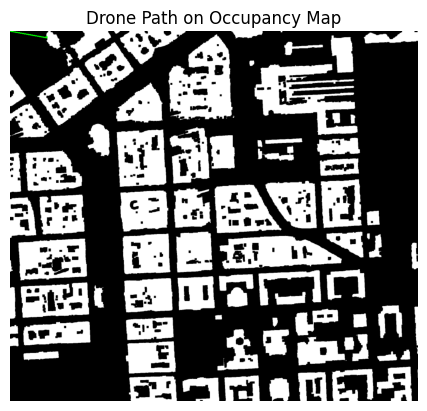

In [80]:
visualize_path_on_map(occupancy_map_path, drone_path)

In [81]:
drone_path_lidar = determine_drone_path_with_lidar(occupancy_map, sensor_log)
df_1 = pd.DataFrame(drone_path_lidar, columns=['x', 'y'])
print(df_1)

              x           y
0      0.000000    0.000000
1      0.000000    5.792179
2      0.000000    5.792179
3      0.000000    5.792179
4      0.000000    5.792179
..          ...         ...
132  691.309374  557.880544
133  691.309374  557.880544
134  691.309374  557.880544
135  691.309374  557.880544
136  694.846587  557.880544

[137 rows x 2 columns]


In [98]:
dynamic_path = dynamic_drone_distance_lidar(occupancy_map, sensor_log, max_steps=200, safety_distance_fraction=0.1)
df_2 = pd.DataFrame(dynamic_path, columns = ['x', 'y'])
print(df_2)

              x           y
0     75.619320    5.874107
1     76.434324   19.418665
2    125.538131   51.704806
3    145.977613   90.374107
4    122.186431  108.720125
..          ...         ...
291   93.865193  126.086468
292   74.303291  139.783860
293   25.078239  130.452040
294    5.803291   98.138379
295   75.724641    8.809359

[296 rows x 2 columns]


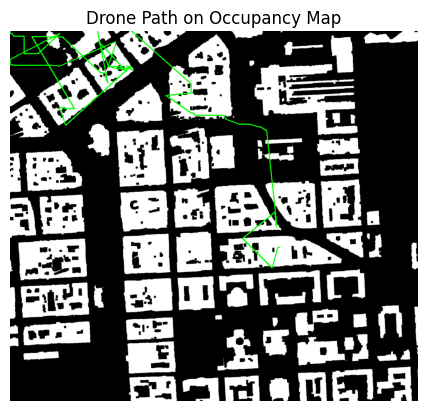

In [96]:
visualize_path_on_map(occupancy_map_path, drone_path_lidar)

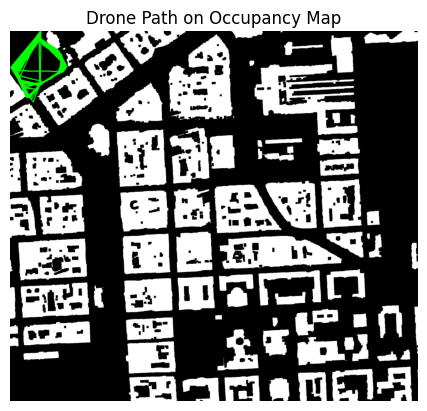

In [97]:
visualize_path_on_map(occupancy_map_path, dynamic_path)